# Deep Learning Mini Project S24

## Zhenyuan Dong, Zhanhao Liu, Jiaheng Yu

Plot "Training Loss vs Iterations"

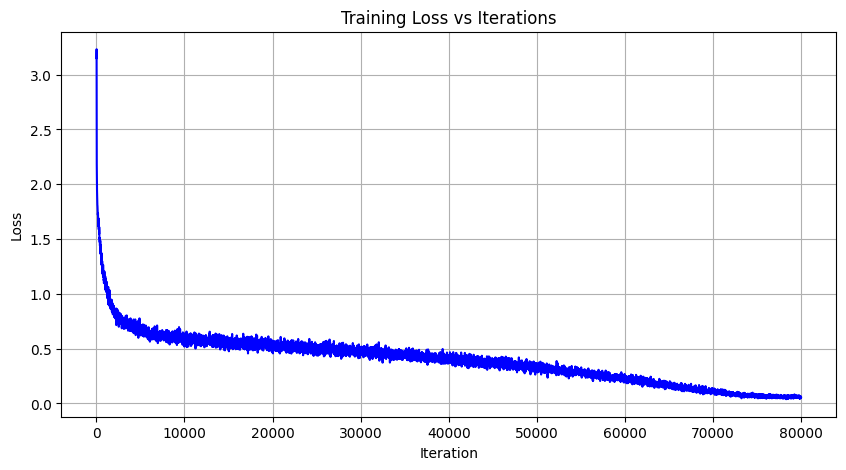

In [7]:
import matplotlib.pyplot as plt
import numpy as np
iters = []
losses = []


with open('./checkpoint/loss_log.txt', 'r') as file:
    file.readline()  
    for line in file:
        parts = line.split(',')
        iter_part = parts[0].strip()
        loss_part = parts[1].strip()

        iter_number = int(iter_part.split(':')[1].strip())
        loss_value = float(loss_part.split(':')[1].strip())

        iters.append(iter_number)
        losses.append(loss_value)
test_acc=np.load('./checkpoint/test_acc.npy')
test_acc=test_acc/100
x1=np.arange(500,80500,500)
iters=np.array(iters)
losses=np.array(losses)

plt.figure(figsize=(10, 5))
plt.plot(iters, losses, linestyle='-', color='b')
plt.title('Training Loss vs Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Plot "Training loss and test accuracy with iterations"

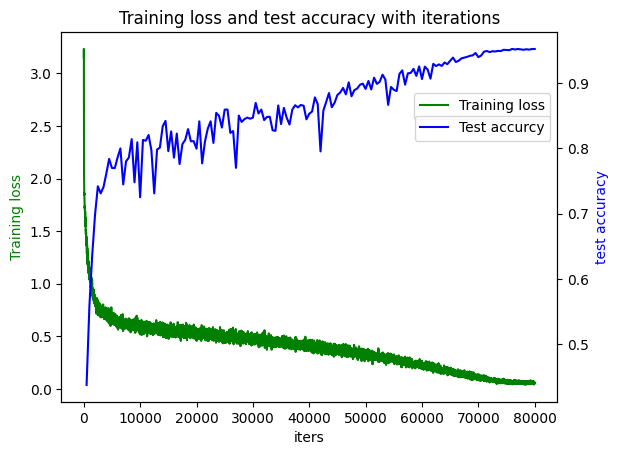

In [8]:
fig, ax1 = plt.subplots()
  
ax1.plot(iters, losses, 'g-',label='Training loss')  
ax1.set_xlabel('iters')
ax1.set_ylabel('Training loss', color='g')  
ax1.tick_params(axis='y')

ax2 = ax1.twinx() 
ax2.plot(x1, test_acc, 'b-',label='Test accurcy')  
ax2.set_ylabel('test accuracy', color='b')
ax2.tick_params(axis='y')

ax1.legend(loc='center right',bbox_to_anchor=(1, 0.8))
ax2.legend(loc='center right',bbox_to_anchor=(1, 0.74))

plt.title('Training loss and test accuracy with iterations')
plt.show()

We have observed that the images in the CIFAR-10 dataset have a resolution of 32x32 pixels, 
which is relatively small compared to other datasets. Consequently, to retain more information during training, 
it is advisable to utilize smaller kernel sizes and remove maxpooling from the network architecture.

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

import nets



def conv3x3(in_channels,out_channels,stride=1):
    return nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=3,stride=stride,padding=1,bias=False)


def init_weights(net, gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            nn.init.normal_(m.weight.data, 1.0, gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)

class BasicBlockReduced(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlockReduced, self).__init__()
        # Adjust conv layers to have fewer channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)


        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNetReduced(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNetReduced, self).__init__()
        self.in_channels = 32  # Reduced initial channels
        #self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1, padding=3, bias=False)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        # We have observed that the images in the CIFAR-10 dataset have a resolution of 32x32 pixels, 
        # which is relatively small compared to other datasets. Consequently, to retain more information during training, 
        # it is advisable to utilize smaller kernel sizes and remove maxpooling from the network architecture.
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)  # Adjusted based on final layer channels

    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Define the forward pass
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    def resnet18_reduced(**kwargs):
        # Adjust the layer configuration to reduce complexity
        model = ResNetReduced(BasicBlockReduced, [2, 2, 2, 2], **kwargs)
        return model

class ResNetModel:
    def __init__(self, train=True):
        # Initialize the reduced ResNet model.
        self.net = ResNetReduced(BasicBlockReduced, [2, 2, 2, 2], num_classes=10)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(self.device)
        self.net.to(self.device)

        # Use DataParallel for multi-GPU setups.
        if torch.cuda.is_available() and torch.cuda.device_count() > 1:
            self.net = torch.nn.DataParallel(self.net)

        init_weights(self.net)

        # Print the total number of parameters in the model.
        num_params = sum(p.numel() for p in self.net.parameters())
        print(f'Total number of parameters : {num_params / 1e6:.3f} M')

        self.checkpoint_dir = './checkpoint' if train else None
        if train:
            self.net.train()
            self.set_optimizer()
            self.criterion = nn.CrossEntropyLoss()
            self.loss = 0.0
        else:
            self.net.eval()

    def set_optimizer(self):
        
        self.optimizer = optim.SGD(
                self.net.parameters(),
                lr=0.1,
                momentum=0.9,
                weight_decay=0.0001 
            )
        

        self.scheduler = optim.lr_scheduler.MultiStepLR(
            self.optimizer,
            milestones=[50, 100],
            gamma=0.1
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=200)

    def optimize_params(self, x, label):
        x, label = x.to(self.device), label.to(self.device)
        self.optimizer.zero_grad()
        y = self._forward(x)
        self.loss = self.criterion(y, label)
        self.loss.backward()
        self.optimizer.step()

    def _forward(self, x):
        return self.net(x)

    def test(self, x, label=None):
        x = x.to(self.device)
        with torch.no_grad():
            outputs = self._forward(x)
            _, predicted = torch.max(outputs, 1)
            
            if label is not None:
                label = label.to(self.device)
                total = label.size(0)
                correct = (predicted == label).sum().item()
                return correct, total, predicted
            else:
                # 'predicted' is a tensor of predicted labels
                return None, None, predicted


    def val(self, x, label):
        x, label = x.to(self.device), label.to(self.device)
        with torch.no_grad():
            y = self._forward(x)
            loss = self.criterion(y, label)
        return loss.item()

    def save_model(self, name):
        path = os.path.join(self.checkpoint_dir, f'model_{name}.pth')
        torch.save(self.net.state_dict(), path)
        print(f'model saved to {path}')


    def load_model(self, path):
        self.net.load_state_dict(torch.load(path))
        print(f'model loaded from {path}')


    def get_current_loss(self):
        return self.loss.item()



Data Augmentation

In [10]:
import random
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import numpy as np
import torch

import torch
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
class Cutout(object):
    """
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
        # (x,y) is the center of cutting
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img
    
    
class CIFARTestNoLabels(Dataset):
    def __init__(self, file_path, transform=None):
        self.data_dict = unpickle(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data_dict[b'data'])

    def __getitem__(self, idx):
        img = self.data_dict[b'data'][idx]
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)  # Convert to HxWxC format
        img = transforms.ToPILImage()(img)
        
        if self.transform:
            img = self.transform(img)

        return img

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



def get_dataloader(is_train, batch_size, path, external_dataset_path=None):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # Randomly crop the data
        transforms.RandomHorizontalFlip(),  # Flip the data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # Normalize the data
        Cutout(n_holes=1, length=16), # Use "Cutout" trick to enhence the training 
    ])


    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

    if external_dataset_path is not None:
        dataset = CIFARTestNoLabels(external_dataset_path, transform=transform_test)
        return DataLoader(dataset, batch_size=batch_size, shuffle=False)
    else:
        if is_train:
            return DataLoader(
                datasets.CIFAR10(path,
                                train=True,
                                download=True,
                                transform=transform_train),
                batch_size=batch_size,
                shuffle=True
            )
        else:
            return DataLoader(
                datasets.CIFAR10(path,
                                train=False,
                                download=True,
                                transform=transform_test),
                batch_size=batch_size,
                shuffle=False
        )


Print the final test accuracy and number of parameters

In [11]:
import os
import torch
import data
import models
import options
import numpy as np


def test():
    
    dataset_dir='./dataset'
    dataloader = data.get_dataloader(False, 128, dataset_dir)
    model = ResNetModel(train=False)
    model.load_model('./checkpoint/model_79000.pth')

    total_n = 0
    total_correct = 0
    label=[]
    pr=[]
    for batch in dataloader:
        inputs, labels = batch
        correct, total, preds = model.test(inputs, labels)
        total_correct += correct
        total_n += total
        label.append(labels)
        pr.append(preds)
    label = torch.cat(label, dim = 0)
    pr = torch.cat(pr, dim = 0)
    label = label.cpu().numpy()
    pr = pr.cpu().numpy()
    acc = 100 * total_correct / total_n
    err = 100 - acc
    print(f'accuracy: {acc:.2f} %')
    print(f'error: {err:.2f} %')
    print(f'{total_correct} / {total_n}')
    return label,pr



labels,pred_label=test()

Files already downloaded and verified
cuda
Total number of parameters : 2.798 M
model loaded from ./checkpoint/model_79000.pth
accuracy: 95.14 %
error: 4.86 %
9514 / 10000


Display a confusion matrix obtained by applying our best model to the training dataset

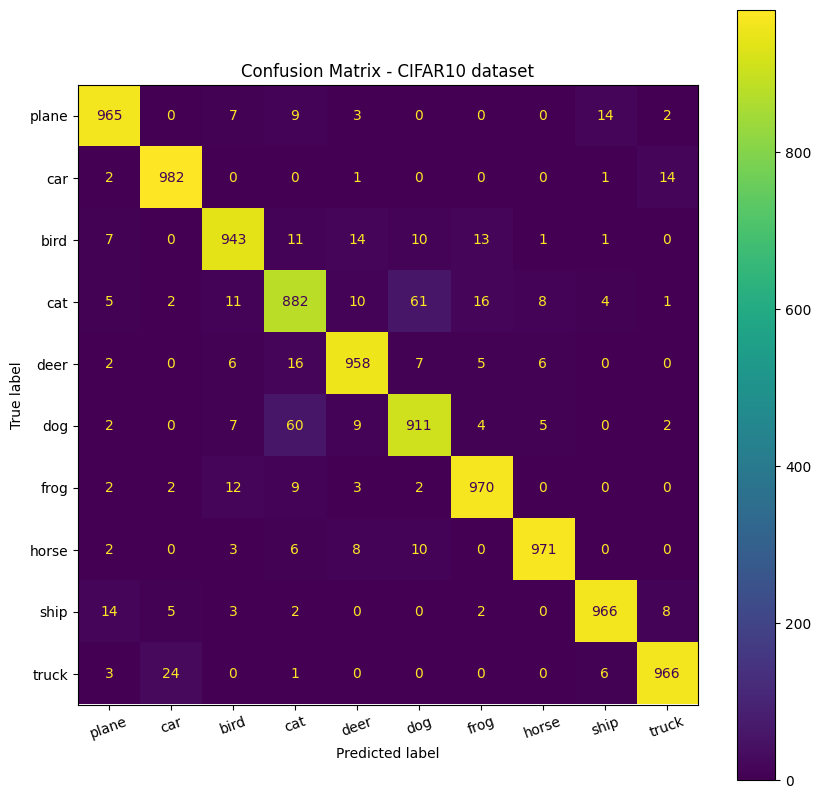

In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    plt.title('Confusion Matrix - CIFAR10 dataset')
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd',ax=ax)
    
    plt.xticks(rotation = 20)

plot_confusion_matrix(labels, pred_label, classes) 